# GitHub API REST v3 -> 貢献者の特徴(その1)
ここでは貢献者がどのような特徴を持っているかを確認します。

## 調べる内容
- 勤め先のばらつき
- ロケーションのばらつき
- 貢献者が保有するフォロワー数のばらつき

## リポジトリの確認と指定方法
例えば以下の条件で調べると, microsoft/vscodeと出てきます。
- microsoft -> owner
- vscode -> repo

https://github.com/search?q=vscode 

In [1]:
# input values
owner = "microsoft"
repo = "vscode"

print("[owner]{0} [repo]{1}について出力します。".format(owner, repo))

import datetime
print("実行日:{0}".format(datetime.datetime.now()))

[owner]microsoft [repo]vscodeについて出力します。
実行日:2020-09-04 09:09:50.979819


## ライブラリのインポート

In [2]:
# Libraries
import requests
import json
import pprint
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

## original Libraries
import config_manager as cnf
import github_api.github_api_manager as gapi

## ユーザー情報の取得
- ユーザー名とパスワードを取得します。
- ユーザー情報は、config\setting.cnfに設定します。

In [3]:
# load config file
cnf_data = cnf.confg_manager()
cnf_data.load()
username, userpassword = cnf_data.get_userparam()

# create github api object
gapi_ctrl = gapi.github_api_manager(username, userpassword)

## GitHub APIを叩いてContributorsの情報を取得します
ページで分けて取らないといけないようなので、
データの取得数が0になるまで取り続けます。

In [4]:

# create repository api
github_api = "/repos/{owner}/{repo}/contributors?page={0}&per_page={1}" \
    .replace("{owner}", owner).replace("{repo}", repo)

page = 0
per_page = 30
ret_json = gapi_ctrl.get_json(github_api.format(page, per_page))

# create Empty dataframe
df = pd.DataFrame(index=[], columns=ret_json[0].keys())

while len(ret_json) > 0:
    # apend data
    for k in ret_json:
        df = df.append(pd.DataFrame.from_dict(k, orient='index').T)

    page = page + 1
    ret_json = gapi_ctrl.get_json(github_api.format(page, per_page), False)

# cast int
df['contributions'] = df['contributions'].astype(float)

# information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 0
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   login                398 non-null    object 
 1   id                   398 non-null    object 
 2   node_id              398 non-null    object 
 3   avatar_url           398 non-null    object 
 4   gravatar_id          398 non-null    object 
 5   url                  398 non-null    object 
 6   html_url             398 non-null    object 
 7   followers_url        398 non-null    object 
 8   following_url        398 non-null    object 
 9   gists_url            398 non-null    object 
 10  starred_url          398 non-null    object 
 11  subscriptions_url    398 non-null    object 
 12  organizations_url    398 non-null    object 
 13  repos_url            398 non-null    object 
 14  events_url           398 non-null    object 
 15  received_events_url  398 non-null    objec

# 貢献者の個別情報を取得します
1人ずつとってくるので結構時間がかかります。

In [5]:
if(len(df) > 0):
    ret_json = gapi_ctrl.get_json_url(df.iloc[0,:]['url'])
    # create Empty dataframe
    df2 = pd.DataFrame(index=[], columns=ret_json.keys())

    for x in df['url']:
        # request github api
        ret_json = gapi_ctrl.get_json_url(x, False)
        # apend data
        df2 = df2.append(pd.DataFrame.from_dict(ret_json, orient='index').T)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 0
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   login                398 non-null    object
 1   id                   398 non-null    object
 2   node_id              398 non-null    object
 3   avatar_url           398 non-null    object
 4   gravatar_id          398 non-null    object
 5   url                  398 non-null    object
 6   html_url             398 non-null    object
 7   followers_url        398 non-null    object
 8   following_url        398 non-null    object
 9   gists_url            398 non-null    object
 10  starred_url          398 non-null    object
 11  subscriptions_url    398 non-null    object
 12  organizations_url    398 non-null    object
 13  repos_url            398 non-null    object
 14  events_url           398 non-null    object
 15  received_events_url  398 non-null    object
 16  type      

棒グラフ表示用の関数

In [6]:
def show_barchart(sr, top_rank, figsize, xlabel, ylabel, title):
    bar_width = 0.35
    
    # show bar chart
    sr2 = sr.head(top_rank)
    x = np.arange(len(sr2.index))
    fig, ax = plt.subplots(figsize = figsize)

    ax.set_xticklabels(sr2.index)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(labelrotation=90)
    rect = ax.bar(sr2.index, sr2.values, bar_width)
    plt.show()

# 貢献者の勤め先

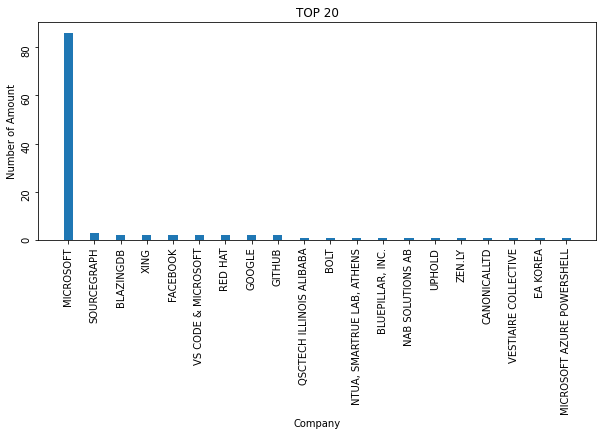

In [7]:
sr = df2['company'].str.upper().str.strip().str.replace('@','').value_counts()
top_rank = 20
bar_width = 0.35

show_barchart(sr, top_rank, (10,4), 'Company', 'Number of Amount', 'TOP {0}'.format(top_rank))

# 貢献者のロケーション

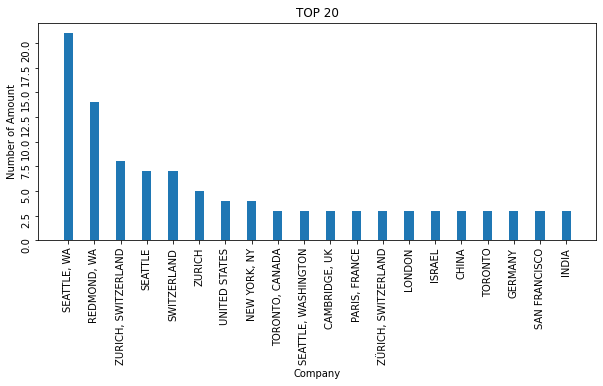

In [8]:
sr = df2['location'].str.upper().str.strip().str.replace('@','').value_counts()
show_barchart(sr, top_rank, (10,4), 'Company', 'Number of Amount', 'TOP {0}'.format(top_rank))


# 貢献者のフォロワー数

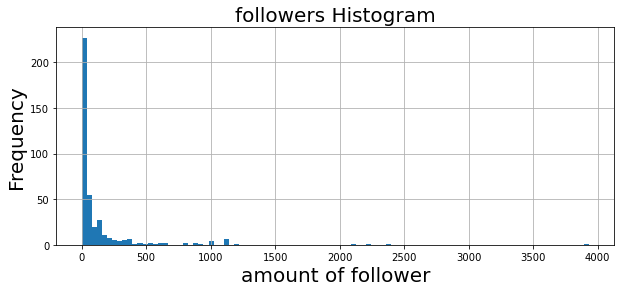

In [9]:
plt.title("followers Histogram".format(repo), fontsize=20)  # title
plt.xlabel("amount of follower", fontsize=20)            # x-axis label
plt.ylabel("Frequency", fontsize=20)      # y-axis label

df2.followers.hist(bins=100, figsize = (10,4))

# フォロワー数100人以下の貢献者の数

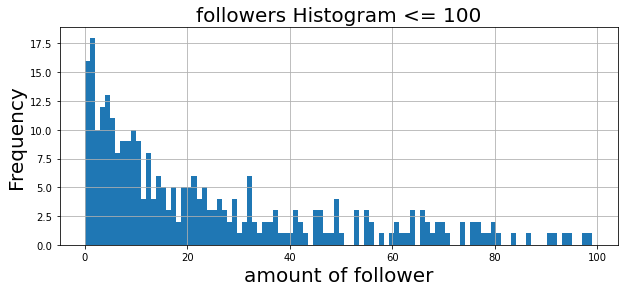

In [10]:
plt.title("followers Histogram <= 100".format(repo), fontsize=20)  # title
plt.xlabel("amount of follower", fontsize=20)            # x-axis label
plt.ylabel("Frequency", fontsize=20)      # y-axis label

df2[lambda d:d.followers <= 100].followers.hist(bins=100, figsize = (10,4))

# フォロワー数100人超の貢献者数

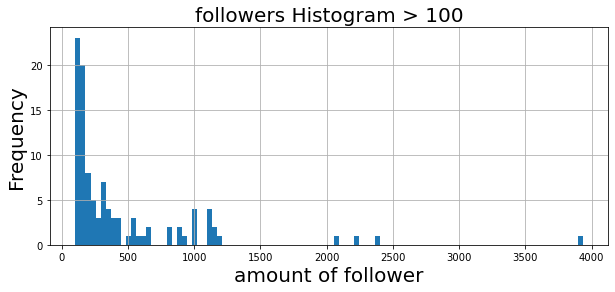

In [11]:
plt.title("followers Histogram > 100".format(repo), fontsize=20)  # title
plt.xlabel("amount of follower", fontsize=20)            # x-axis label
plt.ylabel("Frequency", fontsize=20)      # y-axis label

df2[lambda d:d.followers > 100].followers.hist(bins=100, figsize = (10,4))

In [12]:
df2.head()

,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,gists_url,...,email,hireable,bio,twitter_username,public_repos,public_gists,followers,following,created_at,updated_at
0,bpasero,900690,MDQ6VXNlcjkwMDY5MA==,https://avatars3.githubusercontent.com/u/90069...,,https://api.github.com/users/bpasero,https://github.com/bpasero,https://api.github.com/users/bpasero/followers,https://api.github.com/users/bpasero/following...,https://api.github.com/users/bpasero/gists{/gi...,...,benjpas@microsoft.com,None,I am a software engineer at Microsoft in Zuric...,None,98,21,1007,2,2011-07-07T14:20:44Z,2020-09-01T07:24:48Z
0,joaomoreno,22350,MDQ6VXNlcjIyMzUw,https://avatars3.githubusercontent.com/u/22350...,,https://api.github.com/users/joaomoreno,https://github.com/joaomoreno,https://api.github.com/users/joaomoreno/followers,https://api.github.com/users/joaomoreno/follow...,https://api.github.com/users/joaomoreno/gists{...,...,None,None,VS Code,None,121,22,657,28,2008-08-28T15:00:17Z,2020-09-01T07:50:30Z
0,jrieken,1794099,MDQ6VXNlcjE3OTQwOTk=,https://avatars2.githubusercontent.com/u/17940...,,https://api.github.com/users/jrieken,https://github.com/jrieken,https://api.github.com/users/jrieken/followers,https://api.github.com/users/jrieken/following...,https://api.github.com/users/jrieken/gists{/gi...,...,jrieken@microsoft.com,None,None,None,45,3,305,0,2012-05-30T15:16:06Z,2020-09-03T07:26:48Z
0,mjbvz,12821956,MDQ6VXNlcjEyODIxOTU2,https://avatars2.githubusercontent.com/u/12821...,,https://api.github.com/users/mjbvz,https://github.com/mjbvz,https://api.github.com/users/mjbvz/followers,https://api.github.com/users/mjbvz/following{/...,https://api.github.com/users/mjbvz/gists{/gist...,...,None,None,None,None,144,5,363,1,2015-06-10T00:23:25Z,2020-08-27T19:55:31Z
0,isidorn,1926584,MDQ6VXNlcjE5MjY1ODQ=,https://avatars2.githubusercontent.com/u/19265...,,https://api.github.com/users/isidorn,https://github.com/isidorn,https://api.github.com/users/isidorn/followers,https://api.github.com/users/isidorn/following...,https://api.github.com/users/isidorn/gists{/gi...,...,None,None,VSCode,None,34,1,167,0,2012-07-05T10:05:01Z,2020-08-17T09:40:07Z


In [16]:
japan_cnt = len(df2[lambda d:d.location == 'Japan'])

print("ロケーションがJapanの数:{0}人".format(japan_cnt))

ロケーションがJapanの数:2人
